# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [Student 1]([link](https://github.com/username1)) Alexandre MARTEL
- [Student 2]([link](https://github.com/username2))


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

C:\Users\alexa\AppData\Local\Temp\ipykernel_28968\1573286285.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
C:\Users\alexa\AppData\Local\Temp\ipykernel_28968\1573286285.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
C:\Users\alexa\AppData\Local\Temp\ipykernel_28968\1573286285.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
C:\Users\alexa\AppData\Local\Temp\ipykernel_28968\1573286285.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=

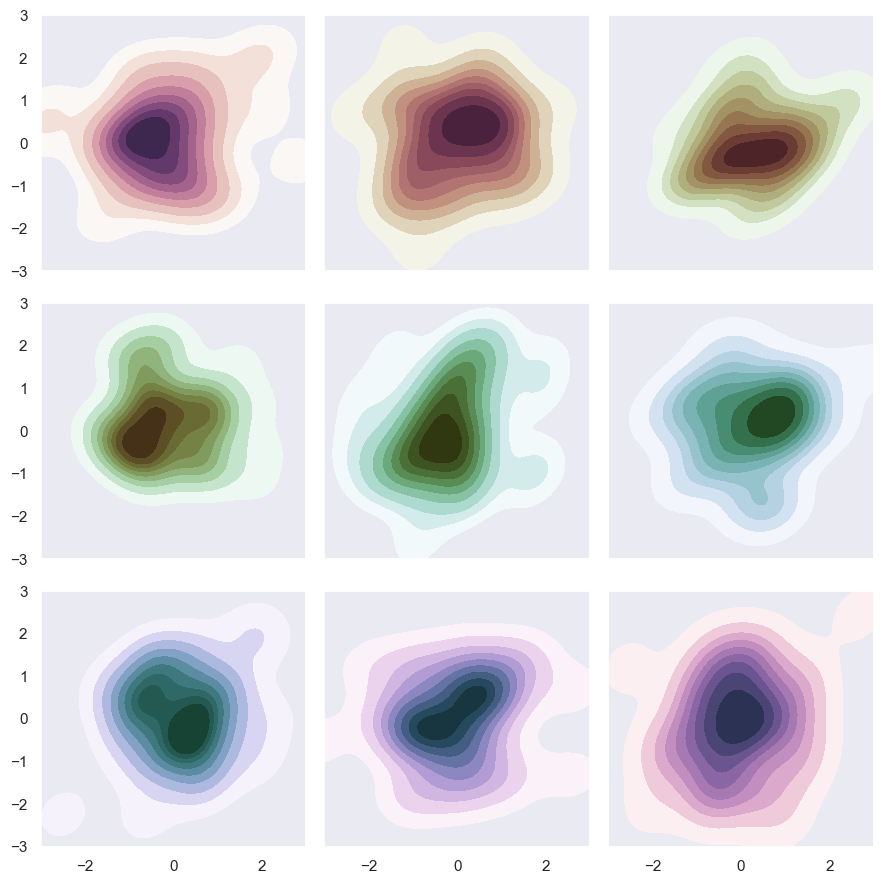

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Met le style en noir
sns.set(style="dark")

rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# On crée plusieurs colormaps en faisant varier le paramètre "start" du début pour obtenir des couleurs différentes dans chaque graphe
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # On créé une palette cubehelix qui est une colormap qui change petit à petit de luminosité tout en restant à peu près uniforme

    # - start=s : change le point de départ des couleurs
    # - light=1 : permet d’aller jusqu’à une couleur claire
    # - as_cmap=True : renvoie une colormap continue
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Génère 50 points aléatoires selon une loi normale pour les coordonnées x et y.
    x, y = rng.normal(size=(2, 50))

    # Kernel Density Estimation

    # Le principe est : Chaque point est remplacé par une gaussienne, elles sont additionnées pour obtenir une fonction de densité lisse qui approxime la proba d’observer des points dans une certaine zone

    # - x, y : les inputs
    # - cmap= cmap : la colormap définie plus haut
    # - shade=True : colore l’intérieur des courbes de densité
    # - cut= 5 : prolonge l’estimation de 5 fois l’écart-type du kernel au-delà des points extrêmes
    # - ax=ax : indique le graph
    sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

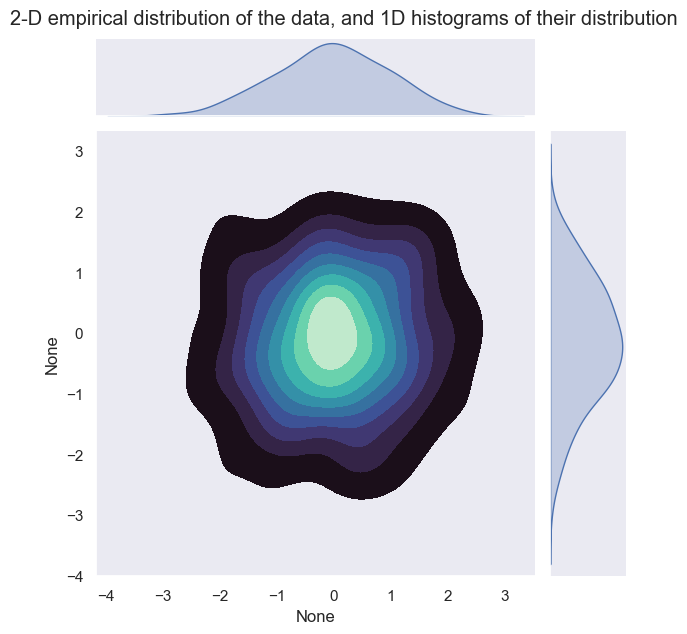

In [5]:
x, y = rng.normal(size=(2, 200))

g = sns.jointplot(x=x, y=y,kind="kde",fill=True,cmap="mako")

# Ajout d’un titre
g.fig.suptitle("2-D empirical distribution of the data, and 1D histograms of their distribution", y=1.02)

plt.show()

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$-th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$) 
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).
   - Examples : **transition matrix `A` should be square** ; **expected `A` to be a stochastic matrix** ; **verify if the size of `A` and `rho` are consistent** ; **verify if `rho` is in the unit simplex**
     - `np.allclose`, `np.isclose` and `np.all` could be useful

> Hints:
> - the function `np.random.choice` can be useful to draw discrete random variables.
> - use `states = np.arange(N)` to create the the labels of the states (from $0$ up to $N-1$)

Here is an example of execution : 
![alternatvie text](img/For_CourseM.png)

**Answer:**

In [ ]:
def markov_chain(rho, A, nmax, rng):
    """
    Stimulate a discrete-time homogeneous Markov chain

    Args:
        rho: law of the initial state (nonnegative vector of size $N$, summing to 1)
        A: transition matrix (of size $N\times N$)nmax: number of time steps
        rng: random number generator

    Returns:
        X: trajectory of the chain
    """

    rho = np.asarray(rho)
    A = np.asarray(A)

    # Check inputs parameters

    # Transition matrix A should be square
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("transition matrix A should be square")
    N = A.shape[0]

    # A is a stochastic matrix
    if not np.all(A >= 0):
        raise ValueError("A must have nonnegative entries")
    if not np.allclose(A.sum(axis=1), 1.0):
        raise ValueError("Each row of A must sum to 1")

    # Size of rho should be consistent with A
    if rho.ndim != 1 or rho.shape[0] != N:
        raise ValueError("size of rho should be consistent with A")

    # rho should be in the unit simplex
    if rho.ndim != 1:
        raise ValueError("rho must be a 1D array")
    if not np.all(rho >= 0):
        raise ValueError("rho must have nonnegative entries")
    if not np.isclose(rho.sum(), 1.0):
        raise ValueError("rho must sum to 1")

    # Simulate the chain
    X = np.empty(nmax, dtype=int)
    X[0] = rng.choice(N, p=rho)
    for n in range(1, nmax):
        X[n] = rng.choice(N, p=A[X[n-1], :])
    return X


2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

In [ ]:
# your code

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

**Answer:**

In [ ]:
# your code

4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

In [ ]:
# your code

## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

J'ai seulement fait des fonctions de test qui ne sont pas vraiment utilisables, mais qui servent simplement à tester.

**Answer:**

In [ ]:
import numpy as np

def gradient2D(X):
    dx = np.diff(X, axis=1, append=X[:, -1:])
    dy = np.diff(X, axis=0, append=X[-1:, :])
    return np.stack((dx, dy), axis=2)

def tv(X):
    grad = gradient2D(X)
    return np.sum(np.sqrt(np.sum(grad**2, axis=2)))

In [ ]:
import dask.array as da

def gradient2D_dask(X):
    dx = da.diff(X, axis=1, append=X[:, -1:])
    dy = da.diff(X, axis=0, append=X[-1:, :])
    return da.stack([dx, dy], axis=2)

def tv_dask(X):
    grad = gradient2D_dask(X)
    return da.sqrt((grad**2).sum(axis=2)).sum()


In [12]:
import numba

@numba.jit(nopython=True, parallel=True)
def gradient2D_numba(X):
    dx = np.diff(X, axis=1, append=X[:, -1:])
    dy = np.diff(X, axis=0, append=X[-1:, :])
    grad = np.stack((dx, dy), axis=2)
    return np.sqrt((grad**2).sum(axis=2)).sum()

def tv_dask_numba(dX):
    return dX.map_blocks(gradient2D_numba, dtype=float).sum()

In [13]:
# Grande matrice pour beaucoup de computations
X = np.random.rand(10000, 10000)
dX = da.from_array(X, chunks=(1000, 1000))

import time


t0 = time.time()
res_numpy = tv(X)
t_numpy = time.time() - t0
print("NumPy:", res_numpy, "temps =", t_numpy, "s")

t0 = time.time()
res_dask = tv_dask(dX).compute()
t_dask = time.time() - t0
print("Dask :", res_dask, "temps =", t_dask, "s")

t0 = time.time()
res_dask = tv_dask(dX).compute()
t_dask = time.time() - t0
print("Numba :", res_dask, "temps =", t_dask, "s")

NumPy: 51781688.558415584 temps = 4.92290735244751 s
Dask : 51781688.55841557 temps = 1.690640926361084 s
Numba : 51781688.55841557 temps = 1.685328722000122 s


In [22]:
import dask

X = np.random.rand(10000, 10000)

def gradient2D_dask_bis(X):
    dx = da.diff(X, axis=1, append=X[:, -1:])
    dy = da.diff(X, axis=0, append=X[-1:, :])
    grad = da.stack([dx, dy], axis=2)
    return da.sqrt((grad**2).sum(axis=2)).sum()

@dask.delayed
def process(X):
    data = gradient2D_dask_bis(X)
    return data

results = [process(X) for _ in range(1)]

t0 = time.time()
res_dask = dask.compute(results)
t_dask = time.time() - t0
print("dask.delayed -" , "temps =", t_dask, "s")

dask.delayed - temps = 0.8469047546386719 s


On remarque que les différentes méthodes améliorent beaucoup le temps d'execution